In [1]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

In [2]:
# Hyperparameters
batch_size = 64

In [3]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
# Download and load the dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [5]:
# Split the dataset into training and testing sets
train_indices, test_indices = train_test_split(range(len(mnist_dataset)), test_size=0.2, random_state=42)

train_dataset = Subset(mnist_dataset, train_indices)
test_dataset = Subset(mnist_dataset, test_indices)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Verify the data loaders
print(f'Train dataset size: {len(train_loader.dataset)}')
print(f'Test dataset size: {len(test_loader.dataset)}')

Train dataset size: 48000
Test dataset size: 12000


In [7]:
import torch.nn as nn

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 6 * 6, 128)  # Adjust the input size according to the output size from conv layers
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Pass the input through the first convolutional layer
        x = self.pool1(self.relu1(self.conv1(x)))
        
        # Pass the input through the second convolutional layer
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # Flatten the output
        x = x.view(-1, 64 * 6 * 6)  # Adjust according to the output size from conv layers
        
        # Pass the input through the fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [9]:
# Instantiate the model and print its architecture
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
import torch.optim as optim
import matplotlib.pyplot as plt

In [11]:
# Hyperparameters
num_epochs = 5
learning_rates = [0.01, 0.001, 0.0001]

In [12]:
# Function to train and evaluate the model
def train_and_evaluate(learning_rate):
    # Instantiate the model and move it to the device (CPU or GPU)
    model = CNN().to(device)
    
    # Define the loss function (Cross-Entropy Loss)
    criterion = nn.CrossEntropyLoss()
    
    # Define the optimizer (SGD with momentum)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # Lists to store training losses and test accuracies for each epoch
    train_losses = []
    test_accuracies = []
    
    # Training loop for the specified number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Variable to accumulate loss during training
        
        # Loop over the training data
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the device
            
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass: compute predictions
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass: compute gradients
            optimizer.step()  # Update the model parameters
            
            running_loss += loss.item()  # Accumulate the loss
        
        # Compute the average training loss for the current epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)  # Store the training loss
        
        model.eval()  # Set the model to evaluation mode
        misclassified_images = []
        misclassified_labels = []
        misclassified_preds = []
        correct = 0  # Variable to count correct predictions
        total = 0  # Variable to count total predictions
        
        # Loop over the test data
        with torch.no_grad():  # Disable gradient computation for efficiency
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to the device
                outputs = model(images)  # Forward pass: compute predictions
                _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
                total += labels.size(0)  # Update the total count
                correct += (predicted == labels).sum().item()  # Update the correct count
        
        # Compute the test accuracy for the current epoch
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)  # Store the test accuracy
        
        # Print the progress for the current epoch
        print(f'Learning Rate: {learning_rate}, Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # Return the training losses and test accuracies for all epochs
    return train_losses, test_accuracies


In [13]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Train and evaluate the model for each learning rate
results = {}
for lr in learning_rates:
    train_losses, test_accuracies = train_and_evaluate(lr)
    results[lr] = (train_losses, test_accuracies)

Learning Rate: 0.01, Epoch [1/5], Loss: 0.2314, Accuracy: 97.77%
Learning Rate: 0.01, Epoch [2/5], Loss: 0.0559, Accuracy: 98.31%
Learning Rate: 0.01, Epoch [3/5], Loss: 0.0368, Accuracy: 98.81%
Learning Rate: 0.01, Epoch [4/5], Loss: 0.0284, Accuracy: 99.04%
Learning Rate: 0.01, Epoch [5/5], Loss: 0.0209, Accuracy: 98.97%
Learning Rate: 0.001, Epoch [1/5], Loss: 0.6247, Accuracy: 92.90%
Learning Rate: 0.001, Epoch [2/5], Loss: 0.1911, Accuracy: 95.66%
Learning Rate: 0.001, Epoch [3/5], Loss: 0.1250, Accuracy: 96.32%
Learning Rate: 0.001, Epoch [4/5], Loss: 0.0962, Accuracy: 97.58%
Learning Rate: 0.001, Epoch [5/5], Loss: 0.0805, Accuracy: 97.72%
Learning Rate: 0.0001, Epoch [1/5], Loss: 2.2044, Accuracy: 60.44%
Learning Rate: 0.0001, Epoch [2/5], Loss: 1.6237, Accuracy: 79.03%
Learning Rate: 0.0001, Epoch [3/5], Loss: 0.7214, Accuracy: 86.36%
Learning Rate: 0.0001, Epoch [4/5], Loss: 0.4572, Accuracy: 89.34%
Learning Rate: 0.0001, Epoch [5/5], Loss: 0.3655, Accuracy: 90.95%


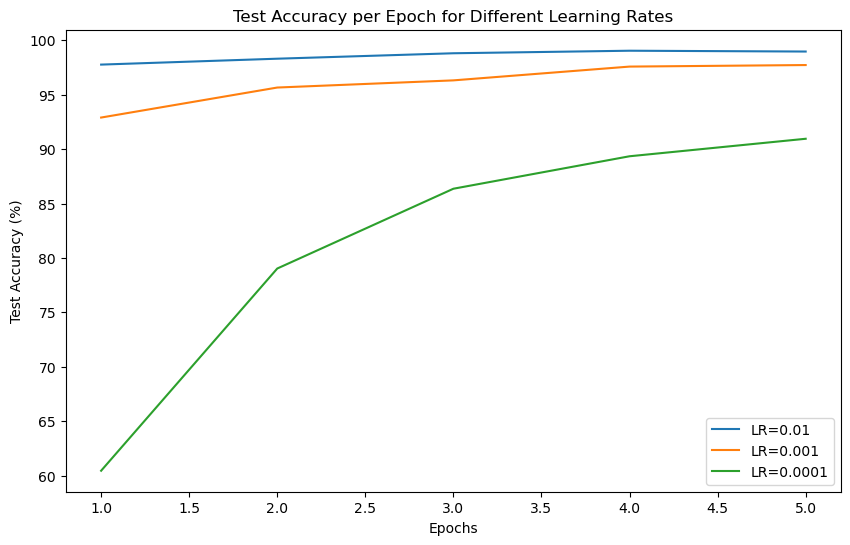

In [15]:
# Plotting results
fig, ax = plt.subplots(figsize=(10, 6))
for lr in learning_rates:
    ax.plot(range(1, num_epochs+1), results[lr][1], label=f'LR={lr}')
ax.set_xlabel('Epochs')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Test Accuracy per Epoch for Different Learning Rates')
ax.legend()
plt.show()

In [16]:
import pandas as pd
# Present results in a table
data = {f'LR={lr}': results[lr][1] for lr in learning_rates}
df = pd.DataFrame(data, index=[f'Epoch {i+1}' for i in range(num_epochs)])
print(df)

           LR=0.01   LR=0.001  LR=0.0001
Epoch 1  97.766667  92.900000  60.441667
Epoch 2  98.308333  95.658333  79.025000
Epoch 3  98.808333  96.316667  86.358333
Epoch 4  99.041667  97.583333  89.341667
Epoch 5  98.966667  97.725000  90.950000
